## Protein-Ligand Interaction Clustering

During the protein-ligand simulations, both protein and ligand undergoes for conformational change, and therefore interaction between them is also evolve and changes during the simulations. Sometime, protein and ligand conformation changes such that interaction remains constant. Capturing similarities in protein-ligand interactions while both are undergoing for changes is challenging. Therefore, clustering of protein-ligand interactions will provide collection of complex conformations that are grouped together by the interactions.

This tutorial provides the steps with examples to perform conformational clustering besed on the protein-ligand interactions. **This method is employed in this [publication](https://pubs.acs.org/doi/full/10.1021/acsinfecdis.4c00531)**. For more details about the theory of the method, please follow the method section of this publication.

### Instructions
* **Tutorial files**: The tutorial files can be downloaded from [here](https://figshare.com/ndownloader/files/55986245).
* **Extract the files**: `tar -zxvf protein-ligand-interaction.tar.gz`
* **Go to directory**: `cd protein-ligand-interaction`
* **Copy the Jupyter Notebook**: This notebook is available in the GitHub repo. [Download and copy it from the github](https://github.com/rjdkmr/gmx_clusterByFeatures/tree/master/docs/tutorials).

### Final result
<p float="left">
  <img src="https://raw.githubusercontent.com/rjdkmr/gmx_clusterByFeatures/master/docs/images/protein-ligand-clusters-front.png" width="450"/>
  <img src="https://raw.githubusercontent.com/rjdkmr/gmx_clusterByFeatures/master/docs/images/protein-ligand-clusters-side.png" width="450"/>
  <img src="https://raw.githubusercontent.com/rjdkmr/gmx_clusterByFeatures/master/docs/images/mmpbsa-binding-energy.png" width="700"/>
  <img src="https://raw.githubusercontent.com/rjdkmr/gmx_clusterByFeatures/master/docs/images/mmpbsa-residues-binding-energy.png" width="1000"/> 
</p>

### Required Tools
* GROMACS
* gmx_clusterByFeatures

### Steps
1. Modification of ligand topology file
2. Calculation of protein-ligand reciprocal-distance-matrix trajectory
3. PCA of the reciprocal-distance-matrix trajectory
4. Calculations of projection of first five PCs on reciprocal-distance-matrix trajectory
5. Pre-Clustering scan for Cluster-Metrics
6. Clustering with pre-determined number of clusters 
7. Analysis
8. MM/PBSA Analysis

### 1. Modification of ligand topology file

In general, whole ligand is considered as a single residue. At first, ligand's atoms are grouped as several residues and these are marked in the topology file as shown below in example. Idea is to divide ligand into virtual residues.

<p float="left">
  <img src="https://raw.githubusercontent.com/rjdkmr/gmx_clusterByFeatures/master/docs/images/ligand-topology.png" width="600"/>
  <img src="https://raw.githubusercontent.com/rjdkmr/gmx_clusterByFeatures/master/docs/images/ligand_virtual_residues.png" width="180"/>
</p>
 

Above right side, ligand is colored by the assigned virtual residues.

**Notes:**
1. The atoms in a residue should be continuous and its ID and Name should be unique.
2. Do not reorder the atoms in topology after simulation is performed because same order is present in trajectory.
3. If required, always reorder atoms during ligand topology generation at the very begining of the simulation setup. In this way, atoms in generated trajectory will have same order as in topology and tpr files.

After, modifying the topology, rerun `gmx grompp` to regenerate tpr file with ligand having virtual residues. Also, create new index files to include make new groups depending on the requirements.

### 2. Calculation of protein-ligand reciprocal-distance-matrix trajectory

Now, we calculate reciprocal-distance matrix using `distmat` sub-command. Since, ligand is now made-up of virtual residues, reciprocal-distance-matrix between ligand and protein will contain reciprocal of minimum-distance between ligand's virtual residues and protein's residues. 

**Notes:**
* `-power -1` option is used to calulate 1/(minimum-distance) in place of minimum-distance.
* Selected index group: `1` is protein and `12` is ligand (Other)

In [1]:
%%bash 

echo 1 12 | gmx_clusterByFeatures distmat -f inputs/trajectory.xtc -s inputs/complex_res_segments.tpr \
                                          -gx 1 -power -1 -var var_lig_protein.dat -cmap cmap_lig_protein.dat -pca pca.xtc

 :-) GROMACS - gmx_clusterByFeatures distmat, 2025.0-dev-20250210-6949615-local (-:

Executable:   gmx_clusterByFeatures distmat
Data prefix:  /project/external/gmx_installed
Working dir:  /home/raj/workspace/gmx_clusterByFeatrues/tutorials/protein-ligand-interaction
Command line:
  'gmx_clusterByFeatures distmat' -f inputs/trajectory.xtc -s inputs/complex_res_segments.tpr -gx 1 -power -1 -var var_lig_protein.dat -cmap cmap_lig_protein.dat -pca pca.xtc


         :-)  gmx_clusterByFeatures distmat (-:

             Author: Rajendra Kumar

       Copyright (C) 2018-2019  Rajendra Kumar


gmx_clusterByFeatures is a free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

gmx_clusterByFeatures is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or

Selected 1: 'Protein'
Selected 12: 'Other'
 Number of distance-matrix elements for PCA trajectory: 6505
 Number of distance-matrix coordinates in PCA trajectory: 2169


### 3. PCA of the reciprocal-distance-matrix trajectory

Now, we will use `pca.xtc` and `pca_dummy.pdb` generated in the above command as input files to GROMACS tool `gmx covar` to perform PCA. This step will calculate covariance matrix, eigenvectors and eigenvalues. By default, the eigenvectors are written in `eigenvec.trr` while eigenvalues are written in `eigenval.xvg` files.

`-nofit`, `-nomwa` and `-nopbc` options are used because `xtc` file does not contain cartesian-coordinates and these option has no meanings in the case of the distance-matrix trajectory.

In [2]:
%%bash

echo 0 0 | gmx covar -f pca.xtc -s pca_dummy.pdb -nofit -nomwa -nopbc

                      :-) GROMACS - gmx covar, 2025.2 (-:

Executable:   /opt/gromacs-2025/bin/gmx
Data prefix:  /opt/gromacs-2025
Working dir:  /home/raj/workspace/gmx_clusterByFeatrues/tutorials/protein-ligand-interaction
Command line:
  gmx covar -f pca.xtc -s pca_dummy.pdb -nofit -nomwa -nopbc

Group     0 (         System) has  2169 elements
Group     1 (        Protein) has  2169 elements
Group     2 (      Protein-H) has  1102 elements
Group     3 (        C-alpha) has   140 elements
Group     4 (       Backbone) has   419 elements
Group     5 (      MainChain) has   558 elements
Group     6 (   MainChain+Cb) has   682 elements
Group     7 (    MainChain+H) has   683 elements
Group     8 (      SideChain) has  1486 elements
Group     9 (    SideChain-H) has   544 elements
Select a group: Calculating the average structure ...
Reading frame   22000 time 440000.000   
Constructing covariance matrix (6507x6507) ...
Reading frame   22000 time 440000.000   
Read 22501 frames

Trace of


         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.


Choose a group for the covariance analysis
Selected 0: 'System'


### 4. Projection of first five PCs on reciprocal-distance-matrix trajectory

We will use eigenvectors written in `eigenvec.trr`, `pca.xtc` and `pca_dummy.pdb` as input files to GROMACS tool `gmx anaeig` to calculate projection of first 5 eigenvectors on distance-matrix trajectory. These projections will be written into `proj.xvg` file.

In [3]:
%%bash

echo 0 0 | gmx anaeig -f pca.xtc -s pca_dummy.pdb -first 1 -last 5 -proj

                      :-) GROMACS - gmx anaeig, 2025.2 (-:

Executable:   /opt/gromacs-2025/bin/gmx
Data prefix:  /opt/gromacs-2025
Working dir:  /home/raj/workspace/gmx_clusterByFeatrues/tutorials/protein-ligand-interaction
Command line:
  gmx anaeig -f pca.xtc -s pca_dummy.pdb -first 1 -last 5 -proj

trr version: GMX_trn_file (single precision)
Eigenvectors in eigenvec.trr were determined without fitting
Read non mass weighted average/minimum structure with 2169 atoms from eigenvec.trr
Read 6507 eigenvectors (for 2169 atoms)


         that are broken across periodic boundaries, they
         cannot be made whole (or treated as whole) without
         you providing a run input file.

Group     0 (         System) has  2169 elements
Group     1 (        Protein) has  2169 elements
Group     2 (      Protein-H) has  1102 elements
Group     3 (        C-alpha) has   140 elements
Group     4 (       Backbone) has   419 elements
Group     5 (      MainChain) has   558 elements
Group     6


Select an index group of 2169 elements that corresponds to the eigenvectors
Selected 0: 'System'



### 5. Pre-Clustering scan for Cluster-Metrics

Before performing final clutering, we would first generate cluster-mterics that can be used to make a decision on the number of clusters. One of the **drawback** of [K-Means clustering](https://en.wikipedia.org/wiki/K-means_clustering) is that the number of clusters should be known beforehand. Although, `gmx_clusterByFeatures` implements several [cluster metrics](https://gmx-clusterbyfeatures.readthedocs.io/en/latest/commands/cluster.html#cmetric-prior) and also automatated way to decide number of clusters, here, we first calculate cluster-metrics and final clustering can be performed later.

Following command will perform the clustering of conformations using first 5 PCs projection. Explanation of options are as follows:
* `-method kmeans`: Use K-Means clustering algorithm
* `-ncluster 15`: K-Means clustering will be performed for 1 upto 15 clusters times each time. Finally, based on `-ssrchange` option, final number of clusters will be automatically selected.
* `-cmetric ssr-sst`: Use Elbow method to decide final number of clusters. It is not for final purpose.
* `-nfeature 5`: Take 5 feature from `feat proj.xvg` input file. Here it is projection of first 5 eigenvectors on the trajectory.
* `-ssrchange 1.0`: Threshold (percentage) of change in SSR/SST ratio in Elbow method to automatically decide the number of clusters.
* `-g clusters_scan.log`: Log file containing clustering information and cluster-mterics.

**index group order**

1. **First index** group - Output group of atoms in the central structures and clustered trajectories

2. **Second index** group - Group of atoms to calculate RMSD between central conformations of clusters as RMSD matrix, which is dumped in the **log file** with `-g` option. Here, it is Ligand.
    
3. **Third index** group - Used for Superimposition by least-square fitting. ONLY used in separate clustered trajectories to superimpose conformations on the central structure. Here, it is protein's C-alpha atoms.

**Content of the output `-g clusters_scan.log` file**

It contains the command summary, and for each input cluster-numbers, number of frames in each clusters. At the end it dumps the **Cluster Metrics Summary**, which is important for deciding final number of clusters.

In [4]:
%%bash

echo 0 12 26 | gmx_clusterByFeatures cluster -f inputs/trajectory.xtc -s inputs/complex_res_segments.tpr -n inputs/index.ndx \
                                            -method kmeans -feat proj.xvg -nfeature 10 -cmetric ssr-sst -ncluster 15 -ssrchange 1.0 \
                                            -g clusters_scan.log

 :-) GROMACS - gmx_clusterByFeatures cluster, 2025.0-dev-20250210-6949615-local (-:

Executable:   gmx_clusterByFeatures cluster
Data prefix:  /project/external/gmx_installed
Working dir:  /home/raj/workspace/gmx_clusterByFeatrues/tutorials/protein-ligand-interaction
Command line:
  'gmx_clusterByFeatures cluster' -f inputs/trajectory.xtc -s inputs/complex_res_segments.tpr -n inputs/index.ndx -method kmeans -feat proj.xvg -nfeature 10 -cmetric ssr-sst -ncluster 15 -ssrchange 1.0 -g clusters_scan.log


         :-)  gmx_clusterByFeatures cluster (-:

             Author: Rajendra Kumar

       Copyright (C) 2018-2019  Rajendra Kumar


gmx_clusterByFeatures is a free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

gmx_clusterByFeatures is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without

  Cluster Log output   

Command:
'gmx_clusterByFeatures cluster' -f inputs/trajectory.xtc -s inputs/complex_res_segments.tpr -n inputs/index.ndx -method kmeans -feat proj.xvg -nfeature 10 -cmetric ssr-sst -ncluster 15 -ssrchange 1.0 -g clusters_scan.log

Choose a group for the output:
Selected 0: 'System'

Choose a group for clustering/RMSD calculation:
Selected 12: 'Other'

Choose a group for fitting or superposition:
Selected 26: 'C-alpha_Other_&_!H*'


 Input Trajectory dt = 20 ps



###########################################
########## NUMBER OF CLUSTERS : 1 ########
###########################################

Cluster-ID	TotalFrames
1		22501



###########################################
########## NUMBER OF CLUSTERS : 2 ########
###########################################

Cluster-ID	TotalFrames
1		15000
2		7501



###########################################
########## NUMBER OF CLUSTERS : 3 ########
###########################################

Cluster-ID	TotalFrames
1		7510
2	

Reading frame       5 time 188780.000   
GROMACS reminds you: "No, no, you're not thinking, you're just being logical." (Niels Bohr)





Cluster-ID	Central Frame	Total Frames 
1		18119		7485
2		3515		5829
3		10774		3872
4		12874		2205
5		833		1672
6		9439		1438



Extracting coordinates of the central structure...


Calculating RMSD between central structures...


 Central structurs - RMSD matrix 
    c1     c2     c3     c4     c5     c6 
 0.000  0.414  0.512  0.479  0.458  0.536 
 0.414  0.000  0.605  0.624  0.214  0.600 
 0.512  0.605  0.000  0.253  0.587  0.221 
 0.479  0.624  0.253  0.000  0.587  0.266 
 0.458  0.214  0.587  0.587  0.000  0.583 
 0.536  0.600  0.221  0.266  0.583  0.000 


### 6. Clustering with pre-determined number of clusters

As can be seen above in Cluster-Metrics table obtained in `clusters_scan.log` file, best scores (both Silhouette and Davies-Bouldin) were obtained for 5 clusters. Therefore, now we will do final clustering with 5 clusters and extract trajectories of these clusters.

Explanation of options are as follows:
* `-method kmeans`: Use K-Means clustering algorithm
* `-ncluster 5`: Five clusters will be generated using K-Means clustering.
* `-cmetric prior`: No cluster-mterics is used, number of clusters is already known.
* `-nfeature 5`: Take 5 feature from `feat proj.xvg` input file. Here it is projection of first 5 eigenvectors on the trajectory.
* `cluster-5`: Cluster log file
* `-cpdb clustered_trajs/central.pdb`: Central structures of each cluster as PDB file
* `-fout clustered_trajs/cluster.xtc`: Trajectory file of each cluster
* `-outframe 1000`: Only first 1000 frame after sorting to be written in cluster trajectory file
* `-sort features`: Sort the conformation in each cluster trajectory file based on the distance between central structure and current conformation in feature sub-space.

**This command could take a long time to execute!**

This command could take a long time to execute because it is writing output trajectory file for each cluster sorted by distance in feature-space. Therefore, it needs **to read input trajectory back-and-forth** many time to extract the conformations in sorted manner. **XTC** format is fast for **back-and-forth** reading, and it still could take long time to dump the output trajectories.

In [5]:
%%bash

mkdir clustered_trajs

echo 0 12 26 | gmx_clusterByFeatures cluster -f inputs/trajectory.xtc -s inputs/complex_res_segments.tpr -n inputs/index.ndx \
                                            -feat proj.xvg -nfeature 5 -method kmeans -cmetric prior -ncluster 5 -g cluster-5 \
                                            -cpdb clustered_trajs/central.pdb -fout clustered_trajs/cluster.xtc -outframe 1000 \
                                            -plot pca-cluster-5.png -sort features

 :-) GROMACS - gmx_clusterByFeatures cluster, 2025.0-dev-20250210-6949615-local (-:

Executable:   gmx_clusterByFeatures cluster
Data prefix:  /project/external/gmx_installed
Working dir:  /home/raj/workspace/gmx_clusterByFeatrues/tutorials/protein-ligand-interaction
Command line:
  'gmx_clusterByFeatures cluster' -f inputs/trajectory.xtc -s inputs/complex_res_segments.tpr -n inputs/index.ndx -feat proj.xvg -nfeature 5 -method kmeans -cmetric prior -ncluster 5 -g cluster-5 -cpdb clustered_trajs/central.pdb -fout clustered_trajs/cluster.xtc -outframe 1000 -plot pca-cluster-5.png -sort features


         :-)  gmx_clusterByFeatures cluster (-:

             Author: Rajendra Kumar

       Copyright (C) 2018-2019  Rajendra Kumar


gmx_clusterByFeatures is a free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

gmx_cluster

  Cluster Log output   

Command:
'gmx_clusterByFeatures cluster' -f inputs/trajectory.xtc -s inputs/complex_res_segments.tpr -n inputs/index.ndx -feat proj.xvg -nfeature 5 -method kmeans -cmetric prior -ncluster 5 -g cluster-5 -cpdb clustered_trajs/central.pdb -fout clustered_trajs/cluster.xtc -outframe 1000 -plot pca-cluster-5.png -sort features

Choose a group for the output:
Selected 0: 'System'

Choose a group for clustering/RMSD calculation:
Selected 12: 'Other'

Choose a group for fitting or superposition:
Selected 26: 'C-alpha_Other_&_!H*'


 Input Trajectory dt = 20 ps



###########################################
########## NUMBER OF CLUSTERS : 5 ########
###########################################

Cluster-ID	TotalFrames
1		7501
2		7485
3		3872
4		2205
5		1438



#####################################
Final number of cluster selected: 5
#####################################

Calculating central structure for cluster-5 ...

Reading frame       4 time 188780.000   <string>:127: MatplotlibDeprecationWarning: The non_interactive_bk attribute was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use ``matplotlib.backends.backend_registry.list_builtin(matplotlib.backends.BackendFilter.NON_INTERACTIVE)`` instead.

Back Off! I just backed up clid.xvg to ./#clid.xvg.1#
Reading frame    4000 time 188780.000   
GROMACS reminds you: "Those people who think they know everything are a great annoyance to those of us who do." (Isaac Asimov)





Cluster-ID	Central Frame	Total Frames 
1		2786		7501
2		18119		7485
3		10774		3872
4		12874		2205
5		9439		1438



Extracting coordinates of the central structure...


Calculating RMSD between central structures...


 Central structurs - RMSD matrix 
    c1     c2     c3     c4     c5 
 0.000  0.418  0.603  0.619  0.599 
 0.418  0.000  0.512  0.479  0.536 
 0.603  0.512  0.000  0.253  0.221 
 0.619  0.479  0.253  0.000  0.266 
 0.599  0.536  0.221  0.266  0.000 


Writing central structure to pdb-files...


Writing trajectory for each cluster...


### 7. Analysis
Now, we will perform following analysis on obtained clusters:

1. **Comparison of RMSDs within and between the clusters**: It will show the qualitative measure of separation of conformations of clusters in term of RMSD.
2. **Plotting PC vs PC cluster-wise**. In fact, this is already plotted in the above obtained `pca-cluster-5.png` file. However, we will focus on first three PCs to demonstrate the distribution of conformation in PC space.
3. **Cluster-ID with time**: We will plot cluster-id as a function of time to analyze, how conformation is changing between clusters as a function of time.

At first, we will load Python modules and define some functions as follows:

In [2]:
import re
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import csv

In [3]:
def read_xvg(filename):
    ''' Read any XVG file and return the data as 2D array where data is row-wise with respect to time.
    '''
    fin = open(filename, 'r')

    data = []
    for line in fin:
        line = line.rstrip().lstrip()
        if not line:
            continue

        if re.search('^#|^@', line) is not None:
                     continue

        temp = re.split('\s+', line)
        data.append(list(map(float, temp)))

    data = np.asarray(data)

    return data.T

#### 1a. Calculation of RMSDs within and between the clusters

At first, we need to calculate RMSDs of complex within and between the clusters using `gmx rms` command as follows.

**Note:** The complex structure is already superimposed when separated cluster-trajectory were written in the previous step, therefore, we are not performing fitting in RMSD calculations below,

Note: Remove `%%capture --no-stdout` and `%%capture --no-stderr` to populate all the output generated from `gmx rms` commands. 

In [8]:
%%capture --no-stdout
%%capture --no-stderr
%%script bash

# make directory for rmsd files
mkdir clustered-rmsd

for i in `seq 1 5`
do
    for j in `seq 1 5`
    do
        echo 26 | gmx rms -f clustered_trajs/cluster_c${j}.xtc -s clustered_trajs/central_c${i}.pdb -n inputs/index.ndx -o clustered-rmsd/c${i}_c${j} -nopbc -fit none
    done
done

#### 1b. Comparison of ligand RMSDs within and between the clusters

We will use Python to plot all the obtained RMSDs above. Conformations in cluster trajectory is sorted by distance in feature-space and therefore, RMSD will be randomly fluctuate. RMSDs within the same cluster is expected to be lowest.

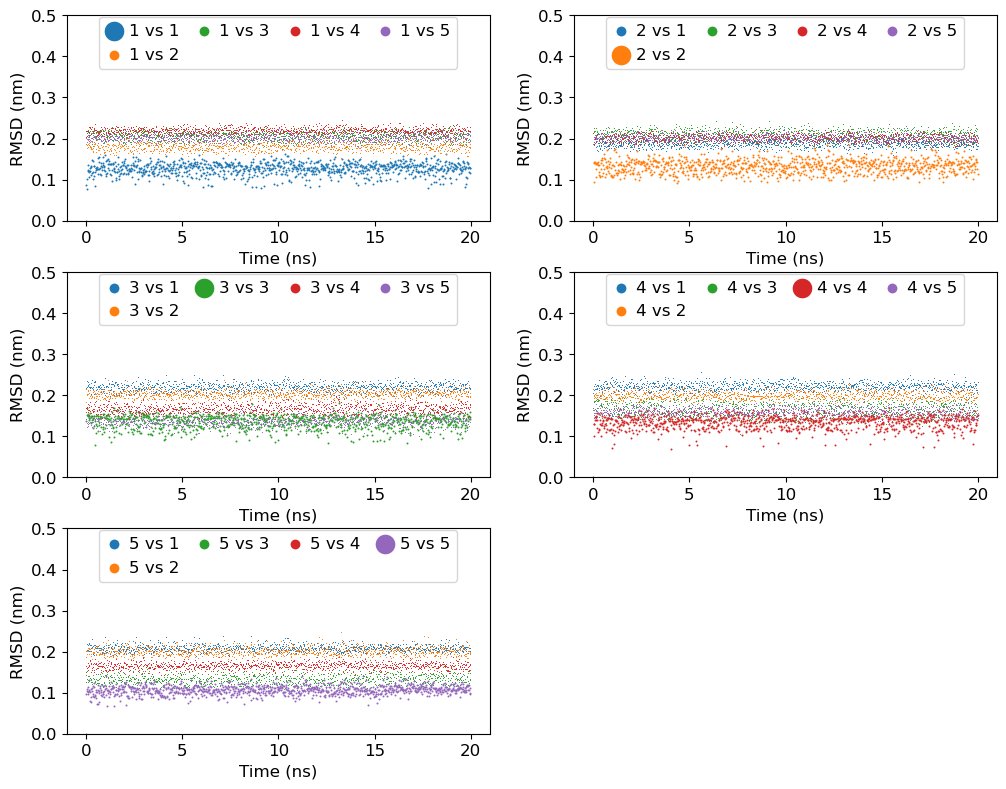

In [9]:
mpl.rcParams['font.size']=12
fig = plt.figure(figsize=(12,16))
fig.subplots_adjust(top=0.98, bottom=0.05, hspace=0.25)

for i in range(1,6):
    
    ax = fig.add_subplot(6, 2, i)
    
    for j in range(1,6):
        filename = 'clustered-rmsd/c{0}_c{1}.xvg'.format(i, j)
        label = "{0} vs {1}".format(i, j)
        data = read_xvg(filename) # read file
        if i==j:
            ax.scatter(data[0]/1000, data[1], label=label, lw=0, s=2)
        else:
            ax.scatter(data[0]/1000, data[1], label=label, lw=0, s=0.5)
        
    ax.set_ylim(0, 0.5)
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('RMSD (nm)')
    plt.legend(loc='upper center', ncol=4, markerscale=10, borderaxespad=0.1, columnspacing=1, handlelength=1, handletextpad=0.4)
    

plt.savefig('rmsd-comparison.png', dpi=300)
plt.show()

#### 3. Plotting PC vs PC cluster-wise

It will be done in two steps:

1. An input file will be prepared containing information about feature searial and their labels.
2. `gmx_clusterByFeatures featuresplot` will be used to generate the plot.

In [1]:
%%bash

# First step - preparation of input file
echo "1,2,PC-1,PC-2" > features-label.txt
echo "2,3,PC-2,PC-3" >> features-label.txt
echo "1,3,PC-1,PC-3" >> features-label.txt
echo "1,4,PC-1,PC-4" >> features-label.txt
cat features-label.txt

# Second step - plotting
gmx_clusterByFeatures featuresplot -i features-label.txt -feat proj.xvg -clid clid.xvg -lcols 6 -o protein-ligand-interaction-PCs-vs-PCs.png
gmx_clusterByFeatures featuresplot -i features-label.txt -feat proj.xvg -clog cluster-5.log -hist -bins 20 -lcols 6 -o protein-ligand-interaction-PCs-vs-PCs-hist.png

1,2,PC-1,PC-2
2,3,PC-2,PC-3
1,3,PC-1,PC-3
1,4,PC-1,PC-4


##### Conformations are highlighted in the feature sub-space: 
<img src="protein-ligand-interaction-PCs-vs-PCs.png" width="900"/> 

##### Histogram of conformations with central structures in the feature sub-space:
<img src="protein-ligand-interaction-PCs-vs-PCs-hist.png" width="900"/> 

#### 3. Cluster-ID with time

We will use `clid.xvg` obtained from the `cluster` subcommand to plot both cluster-id and also highlight the occurance of the given cluster. 

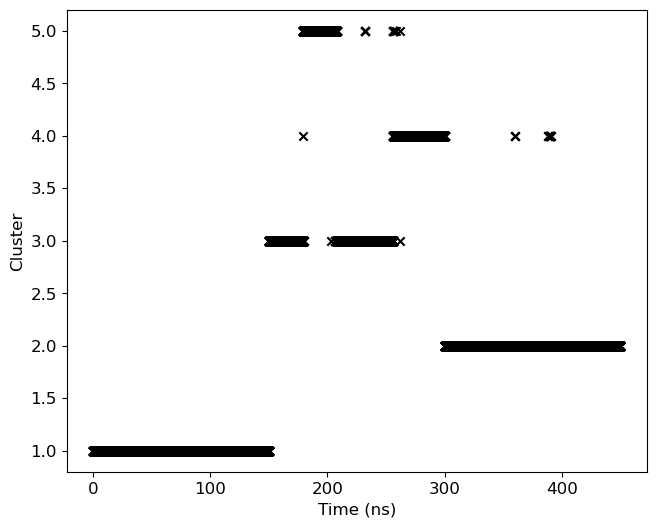

In [11]:
mpl.rcParams['font.size']=12

data=read_xvg('clid.xvg')
fig = plt.figure(figsize=(8,6))
fig.subplots_adjust(right=0.85)

ax = fig.add_subplot(111)
ax.scatter(data[0]/1000, data[1], marker='x', color='k')
ax.set_ylabel('Cluster')
ax.set_xlabel('Time (ns)')

plt.savefig('clid.png', dpi=300)
plt.show()

### 7. MM/PBSA Analysis

**There are advantages of performing MM/PBSA after the clustering:**
1. Speed-up in MM/PBSA calculations - In this particular case, if we have used whole trajectory of 450 ns with a time-difference of 100ps, a total of **4500 frames** will be used for the calcualtions. However, if we restrict MM/PBSA calculations to central structure and near-by conformations in feature-space of each cluster, we could use only few frames for MM/PBSA calculations. For example, if we use only 10 frames per cluster, in total **only 50 frames** will be considered for the calculations. Therefore, we will gain **90 times speed-up** without losing the accuracy in the final average binding energy (shown below).
2. By calculating residues contribution to Binding Energy, we could easily discriminate residues that are forming interactions between diffrent clusters with their interaction strength as energy value.


#### 1. MM/PBSA calculations

Now, we will perform MM/PBSA calculations using [g_mmpbsa](https://g-mmpbsa.readthedocs.io/en/latest/). This will highlight binding energy difference between clusters and also difference in interacting residues that are contributing to the binding.

At first, MM/PBSA calculation is performed as follows. For each cluster, only 10 frames will be used with a virtual time-diffrence of 100 ps for the MM/PBSA calculations. This setup starts calculation with central structure and slowly moves away from it in feature-space and picks 9 more structure from the same cluster.

**Options for MM/PBSA calculations**
* `-dt 100` - consider frame at 100ps time-difference
* `-e 1000` - consider frames upto 1000ps
* `-unit1 1` - First atoms-group for binding energy - here it is protein
* `-unit2 12` - Second atoms-group for binding energy - here it is ligand
* `-pdie 1` - Dielectric constant during MM Electrostatic energy calculation
* `-ddc` - Enable distance-depenedent dielectric constant during MM Electrostatic calculations. It means that farther the atoms from each other, larger the decrease in electrostatic interaction. It particulalry reduces the interaction energy of charged ligand with charged protein-residues that are far apart in the complex, thereby highlighting contribution of charged residues that are only nearby to the ligand. Therefore, it is particulalry useful for protein and charges ligand where residues contribution to binding need to be studied. It does not affect MM van der Waals interaction. **This option should not be used when comparing with experimental binding energy or for final binding energy as the results are not yet validated.**
* `-mme` Enable MM calculations
* `-pbsa` Enable PBSA calcualtions
* `-decomp` Enable binding energy decomposition over residues to calculate residues contribution to binding energy
* `-silent` Do not display output from APBS

**This command could take a long time to execute!**

**Also following command will utilize all the CPU cores to speed-up the calculations**

**Note:** Remove `%%capture --no-stdout` and `%%capture --no-stderr` to populate all the output generated from `gmx rms` commands. 

In [1]:
%%capture --no-stderr
%%capture --no-stdout
%%script bash

mkdir mmpbsa

for i in `seq 1 5`
do
    g_mmpbsa run -s inputs/complex_res_segments.tpr -f clustered_trajs/cluster_c${i}.xtc -n inputs/index.ndx \
                 -i inputs/pbsa.mdp -mm mmpbsa/energy_MM_c${i}.xvg -pol mmpbsa/polar_c${i}.xvg \
                 -apol mmpbsa/apolar_c${i}.xvg -mmcon mmpbsa/residues_MM_c${i}.dat \
                 -pcon mmpbsa/residues_polar_c${i}.dat -apcon mmpbsa/residues_apolar_c${i}.dat \
                 -o mmpbsa/binding_energy_c${i}.xvg -os mmpbsa/energy_summary_c${i}.csv \
                 -ores mmpbsa/residues_energy_summary_c${i}.csv -opdb mmpbsa/energy_c${i}.pdb \
                 -dt 100 -e 1000 -unit1 1 -unit2 12 -pdie 1 -ddc -mme -pbsa -decomp -silent
done

#### 2. Extract and plot binding-energy cluster-wise

We will extract the binding energy from the output CSV file and plot the binding energy for all the clusters.
We will also calculate **weighted average binding energy** (using cluster population) representing final binding energy from full trajectory.

For comparison, we also plot binding energy obtained from **full trajectory with a time-difference of 500ps (900 frames)**. The output files of these calculations are provided in `mmpbsa-full` folder.

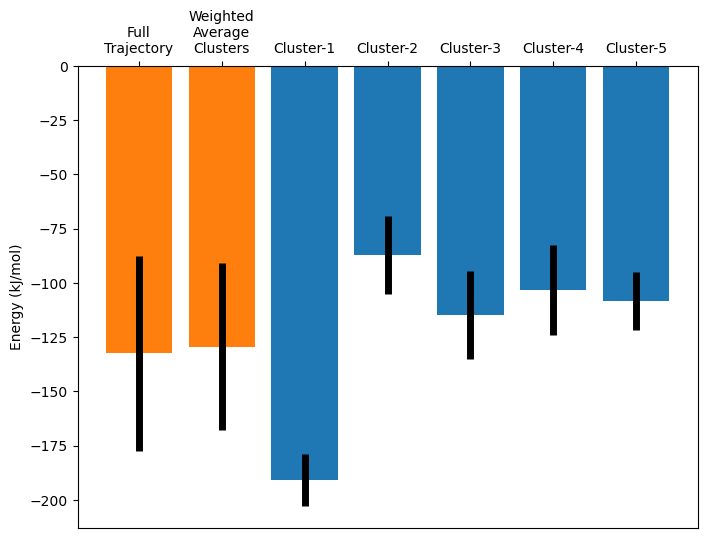

In [51]:
# Population fraction of each cluster, manually calculated from cluster log file
population_weights = [0.333362962, 0.332651882, 0.172081241, 0.097995645, 0.063908271]

# First we extract both average binding energy and its standard deviation for each cluster from respective CSV file
average, stddev = [], []
for i in range(1, 6):
    with open(f'mmpbsa/energy_summary_c{i}.csv') as csvfile:
        reader = csv.DictReader(csvfile, quotechar='"')
        for row in reader:
            if row['Energy'] == 'Total':
                average.append(float(row['Average']))
                stddev.append(float(row['Standard-Deviation']))


# Now calculate weighted avearge and combined standard-deviation
weighted_average = sum([av*wt for av, wt in zip(average, population_weights)])
combined_stddev = 0
for sd, wt in zip(stddev, population_weights): # here we combine SD one-by-one (https://www.statstodo.com/CombineMeansSDs.php)
    if combined_stddev == 0:
        combined_stddev = sd
    else:
        combined_stddev = (combined_stddev**2 + sd**2)**0.5

# Plotting the results
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.bar(np.arange(2, 7), average, yerr = stddev, error_kw={'elinewidth':5})
ax.bar([0, 1], [-132.386, weighted_average], yerr = [45, combined_stddev], error_kw={'elinewidth':5}) # plot energy from full trajectory and weighted average energy from clusters
ax.set_ylabel('Energy (kJ/mol)')
ax.set_xticks(np.arange(0, 7))
ax.set_xticklabels(['Full\nTrajectory', 'Weighted\nAverage\nClusters'] + [f'Cluster-{cid}' for cid in list(np.arange(1, 6))])
ax.tick_params(bottom=False, labelbottom=False, top=True, labeltop=True)
plt.savefig('mmpbsa-binding-energy.png', dpi=300)
plt.show()

#### 3. Extract and plot protein residues contribution to the binding

Here, we extracts residues contribution towards binding that have at least -4 kJ/Mol of energy. This analysis highights the differences 
in interaction residue-wise between the clusters.

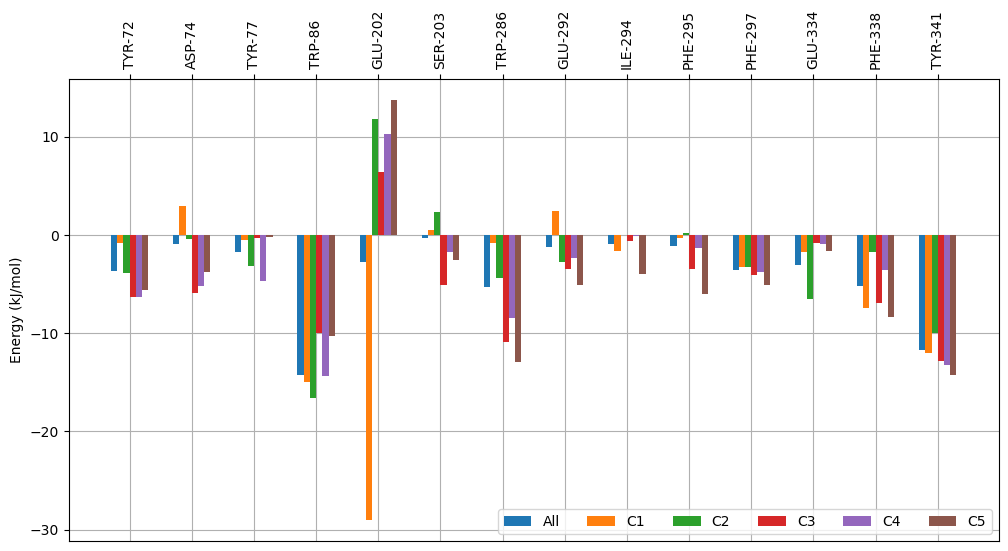

In [31]:
# Population fraction of each cluster, manually calculated from cluster log file
population_weights = [0.333362962, 0.332651882, 0.172081241, 0.097995645, 0.063908271]

# Read CSV files and extract the energy
residues, average_clusters, stddev_clusters = [], [], []
for i in range(1, 6):
    average, stddev = [], []
    with open(f'mmpbsa/residues_energy_summary_c{i}.csv') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            average.append(float(row['total']))
            stddev.append(float(row['total-stddev']))
            if i == 1:
                residues.append(row['Residue'])
    average_clusters.append(average)
    stddev_clusters.append(stddev)

# Calculate weighted-average and add data as first column
weighted_average = np.average(average_clusters, axis=0, weights=population_weights)
average_clusters = [weighted_average, *average_clusters]
average_clusters = np.array(average_clusters)

# First, only consider protein residues, and 
# filter out residues that have equal/less than -4 kJ/mol energy in at least one cluster
average_clusters_only_protein = average_clusters[1:,:-12]                    # there are 12 ligand residues, so discarded last 12
min_values_by_clusters = np.amin(average_clusters_only_protein, axis=0)      # Extract minimum energy values among all clusters
indices_residues_energy_threshold = np.nonzero(min_values_by_clusters < -4)  # Determine the indices of residues that are under the thershold value
filtered_residues = np.asarray(residues)[indices_residues_energy_threshold]  # Extract the residues that are under the thershold value

## Now plot the energies (adapted from here: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py)
x = np.arange(len(filtered_residues))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.grid()

for values in average_clusters[:,indices_residues_energy_threshold[0]]:
    offset = width * multiplier
    if multiplier == 0:
        label = 'All'
    else:
        label = f'C{multiplier}'
    rects = ax.bar(x + offset, values, width, label=label, zorder=10)
    multiplier += 1


ax.set_ylabel('Energy (kJ/mol)')
ax.tick_params(bottom=False, labelbottom=False, top=True, labeltop=True)
ax.set_xticks(x + 0.25, filtered_residues, rotation=90)
ax.legend(loc='lower right', ncols=6)
plt.savefig('mmpbsa-residues-binding-energy.png', dpi=300)
plt.show()

#### 4. Extract and plot ligand residues contribution to the binding

We have divided ligand as collection of virtual-residues. It means, their contribution towards binding energy is also calculated automatically during MM/PBSA calculation. Here, we extracts ligand residues contribution towards binding. This analysis highights the differences in interaction residue-wise between the clusters. This also highlights which part of the ligand is favorable or unfavorable for the binding. 

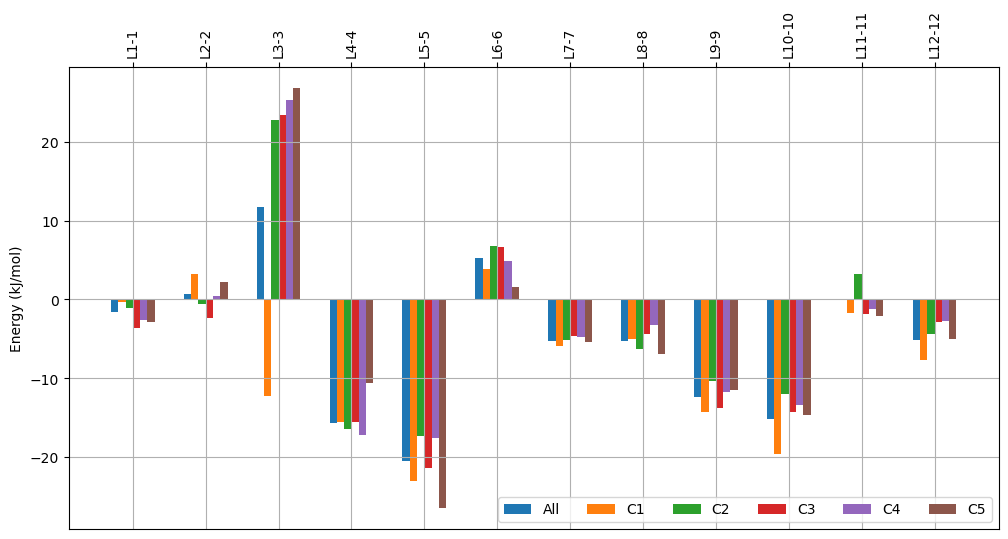

In [34]:
average_clusters_only_ligand = average_clusters[:,-12:]
filtered_residues = np.asarray(residues)[-12:]

x = np.arange(len(filtered_residues))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.grid()

for values in average_clusters_only_ligand:
    offset = width * multiplier
    if multiplier == 0:
        label = 'All'
    else:
        label = f'C{multiplier}'
    rects = ax.bar(x + offset, values, width, label=label)
    multiplier += 1

ax.set_ylabel('Energy (kJ/mol)')
ax.tick_params(bottom=False, labelbottom=False, top=True, labeltop=True)
ax.set_xticks(x + 0.25, filtered_residues, rotation=90)
ax.legend(loc='lower right', ncols=6)
plt.savefig('mmpbsa-ligand-residues-binding-energy.png', dpi=300)
plt.show()